<a href="https://colab.research.google.com/github/johannakin/DD2424-Project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
""" When only wanting to train on 5 classes!"""
# Download data repo from github
#!git clone https://github.com/johannakin/DD2424-Project.git 

""" When wanting to train on all 130 classes!"""
# Load data from drive 

from google.colab import drive
drive.mount('/content/drive')

# Path to all of the data
path_test = '/content/drive/MyDrive/Colab Notebooks/dataset/test' 
path_train = '/content/drive/MyDrive/Colab Notebooks/dataset/train' 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
""" Kommenterat bort de vi inte använder just nu"""
#import os
#import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import keras

#import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras import optimizers
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.preprocessing import image
from keras import models


#from PIL import Image
#from scipy.misc import imsave
from google.colab import drive
import json

In [ ]:
# Path to 5 classes of data
# path_test = '/content/DD2424-Project/data/dataset/test' 
# path_train = '/content/DD2424-Project/data/dataset/train'
# path_val = '/content/DD2424-Project/data/dataset/val' 

In [ ]:
""" Global variables """
NUMBER_OF_LAYERS_TO_FREEZE = 35
NUMBER_OF_CLASSES = 130 # 130 when all data
IMAGE_SIZE = 299 # tror detta är opt. gör mindre - can decrease the accuracy 64
EPOCHS = 6 # FAST
BATCH_SIZE = 200 #  FAST incease 
ETA = 0.001 # 0.001 DONE, 0.01, 0.1 
MOMENTUM = 0.9 #0.0  0.9. 
OPTIMIZER=optimizers.SGD(lr=ETA, momentum=MOMENTUM)



In [ ]:
""" Image augmentation """
# Creating tensors
train_proc = ImageDataGenerator(preprocessing_function = preprocess_input)
val_proc = ImageDataGenerator(preprocessing_function = preprocess_input)
test_proc = ImageDataGenerator(preprocessing_function = preprocess_input)

# Training, validation and test data into variables
train_var = train_proc.flow_from_directory(path_train,
                                           target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                           color_mode='rgb',
                                           batch_size=BATCH_SIZE,
                                           class_mode='categorical',
                                           shuffle=True)

# val_var = val_proc.flow_from_directory(path_val,
#                                          target_size=(IMAGE_SIZE, IMAGE_SIZE),
#                                          color_mode='rgb',
#                                          batch_size=BATCH_SIZE,
#                                          class_mode='categorical',)

test_var = test_proc.flow_from_directory(path_test,
                                         target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                         color_mode='rgb',
                                         batch_size=BATCH_SIZE,
                                         class_mode='categorical',)

Found 65533 images belonging to 130 classes.
Found 5230 images belonging to 130 classes.


In [ ]:
""" Function to initialize pre-trained model, add layers and freeze x  """
# Get pre-trained model and add layers
def preTrain():
    pre_trained_model = InceptionV3(weights='imagenet',include_top=False,
                                         input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    # Add layers on top of pre-trained model
    adding_layers = pre_trained_model.output
    adding_layers = GlobalAveragePooling2D()(adding_layers)
    adding_layers = Dense(1024, activation='relu')(adding_layers)  
    adding_layers = Dense(1024, activation='relu')(adding_layers)  
    adding_layers = Dense(512, activation='relu')(adding_layers)
    final_layer = Dense(NUMBER_OF_CLASSES, activation='softmax')(adding_layers)
    model = Model(inputs=pre_trained_model.input, outputs=final_layer)

    # Freeze numberOfLayersToFreeze layers
    for layer in model.layers[:NUMBER_OF_LAYERS_TO_FREEZE]:
        layer.trainable = False
    for layer in model.layers[NUMBER_OF_LAYERS_TO_FREEZE:]:
        layer.trainable = True

    return model

In [ ]:
def fit(model): # ev lägg in early stopping HÄR 
  # Compile the model
  model.compile(optimizer=OPTIMIZER, loss='categorical_crossentropy', metrics=['accuracy'])

  print("number of epochs: ", EPOCHS)

  error = []
  history = model.fit(train_var,
                      epochs = EPOCHS,
                      batch_size = BATCH_SIZE,
                      verbose = 1,
                      validation_data = test_var,
                      ) #validation_data = test_var,
  
  return model, history

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import model_from_json
from google.colab import files

def saveModel(model):
  from google.colab import drive
  drive.mount('/content/drive')
  # Save model as json
  model_json = model.to_json()
  with open('/content/drive/MyDrive/Colab Notebooks/model_output/model.json', 'w') as json_file:
        json_file.write(model_json)
  
  model.save_weights('/content/drive/MyDrive/Colab Notebooks/model_output/model-weights.h5')

def getModel():
  # from google.colab import drive
  # drive.mount('/content/drive')
  # Get the saved model and convert from json
  json_file = open('/content/drive/MyDrive/Colab Notebooks/model_output/model.json', 'r')
  model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(model_json)
  loaded_model.load_weights('/content/drive/MyDrive/Colab Notebooks/model_output/model-weights.h5')
  
  return loaded_model

In [ ]:
def evaluate(model):
  # Compile the model
  model.compile(optimizer=OPTIMIZER, loss='categorical_crossentropy', metrics=['accuracy'])

  # Get score of model
  [loss, accuracy] = model.evaluate_generator(test_var, test_var.n / BATCH_SIZE, verbose=1)

  return loss, accuracy

In [ ]:
def initTrainEvaluate():
  
  # Call init which initialized pre-trained models, adds new layers, and freezes some
  print("Initialized pre-trained model and adds new layers...")
  init_model = preTrain()

  # Call fit
  print("Training model...")
  model, history = fit(init_model)

  # Call evaluate
  print("Evaluating model...")
  test_loss, test_accuracy = evaluate(model)
  print("Test loss: ", test_loss)
  print("Test accuracy: ", test_accuracy * 100, "%")

  return model, history

In [ ]:
""" Function to plot feature maps """
def map(model):

  #img_path = '/content/DD2424-Project/data/dataset/train/200-n000008-Airedale/n107026.jpg' # to git
  img_path = '/content/drive/MyDrive/Colab Notebooks/dataset/train/200-n000008-Airedale/n107026.jpg' # to drive

  img = image.load_img(img_path, target_size=(299, 299))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.

  # Extracts the outputs of the top 8 layers:
  layer_outputs = [layer.output for layer in model.layers[:8]]
  activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

  activations = activation_model.predict(img_tensor)

  first_layer_activation = activations[0]

  # These are the names of the layers, so can have them as part of our plot
  layer_names = []
  for layer in model.layers[:8]:
      layer_names.append(layer.name)

  images_per_row = 2 #16

  # Display feature maps
  for layer_name, layer_activation in zip(layer_names, activations):
      
      n_features = layer_activation.shape[-1]
      size = layer_activation.shape[1]

      if n_features > 3: images_per_row = 16

      # We will tile the activation channels in this matrix
      n_cols = n_features // images_per_row
      if n_cols == 0: n_cols = 1
      display_grid = np.zeros((size * n_cols, images_per_row * size))

      # We'll tile each filter into this big horizontal grid
      for col in range(n_cols):
        for row in range(images_per_row): # for the different channels
          channel_image = layer_activation[0, :, :, col * images_per_row + row]
          # Post-process the feature to make it visually palatable
          channel_image -= channel_image.mean()
          channel_image /= channel_image.std()
          channel_image *= 64
          channel_image += 128
          channel_image = np.clip(channel_image, 0, 255).astype('uint8')
          display_grid[col * size : (col + 1) * size,
                          row * size : (row + 1) * size] = channel_image
      
      # Display the grid
      scale = 1. / size
      plt.figure(figsize=(scale * display_grid.shape[1],
                          scale * display_grid.shape[0])) #
      plt.title(layer_name)
      plt.grid(False)
      plt.imshow(display_grid, aspect='auto', cmap='viridis')
      
  #plt.show()

In [ ]:
def plot(history):

  # Accuracy plot
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper left')
  plt.show()
  
  # Loss plot
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper left')
  plt.show()

Initialized pre-trained model and adds new layers...
Training model...
number of epochs:  6
Epoch 1/6
328/328 [==============================] - 18561s 57s/step - loss: 3.5362 - accuracy: 0.2603 - val_loss: 4.2244 - val_accuracy: 0.1063
Epoch 2/6
328/328 [==============================] - 823s 3s/step - loss: 1.8520 - accuracy: 0.5700 - val_loss: 2.4813 - val_accuracy: 0.4849
Epoch 3/6
328/328 [==============================] - 839s 3s/step - loss: 1.0423 - accuracy: 0.7556 - val_loss: 0.9371 - val_accuracy: 0.7635
Epoch 4/6
328/328 [==============================] - 839s 3s/step - loss: 0.5857 - accuracy: 0.8323 - val_loss: 0.7374 - val_accuracy: 0.7918
Epoch 5/6
328/328 [==============================] - 839s 3s/step - loss: 0.4573 - accuracy: 0.8618 - val_loss: 0.6603 - val_accuracy: 0.8080
Epoch 6/6
328/328 [==============================] - 838s 3s/step - loss: 0.3636 - accuracy: 0.8876 - val_loss: 0.6602 - val_accuracy: 0.8103
Evaluating model...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


26/26 [==============================] - 34s 1s/step - loss: 0.6828 - accuracy: 0.8071
Test loss:  0.6602378487586975
Test accuracy:  81.0325026512146 %


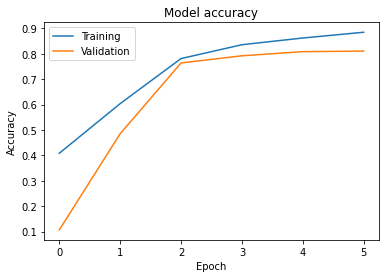

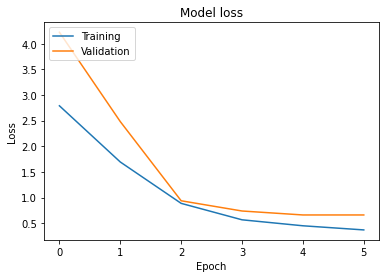

loss validation [4.224410057067871, 2.481292486190796, 0.9370667338371277, 0.7374442219734192, 0.6602604389190674, 0.6602379083633423]
accuracy val [0.10630974918603897, 0.48489484190940857, 0.7634799480438232, 0.7917782068252563, 0.8080306053161621, 0.810325026512146]
Loss [2.789597511291504, 1.6934536695480347, 0.8864179849624634, 0.5658131241798401, 0.44919055700302124, 0.3685269355773926]
Accuracy [0.4081149995326996, 0.603451669216156, 0.7808737754821777, 0.8353348970413208, 0.8617948293685913, 0.8844704031944275]
(1, 299, 299, 3)
299
299
(1, 149, 149, 32)
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
(1, 149, 149, 32)
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
(1, 149, 149, 32)
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
149
(1, 147, 147

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


147
147
147
147
147
147
147
(1, 147, 147, 32)
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
(1, 147, 147, 32)
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
(1, 147, 147, 64)
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147
147


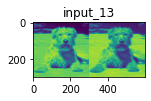

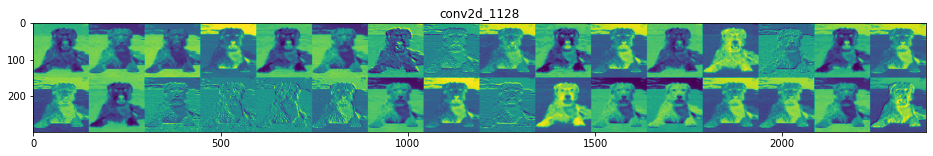

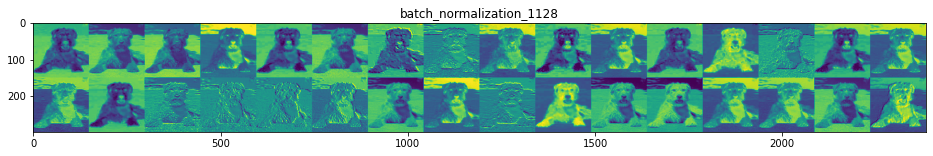

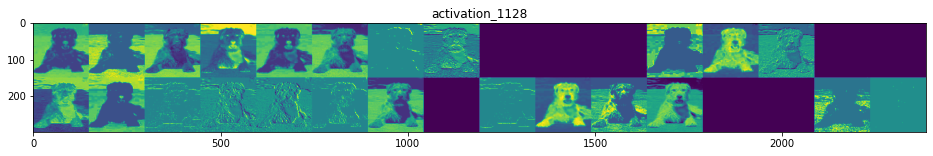

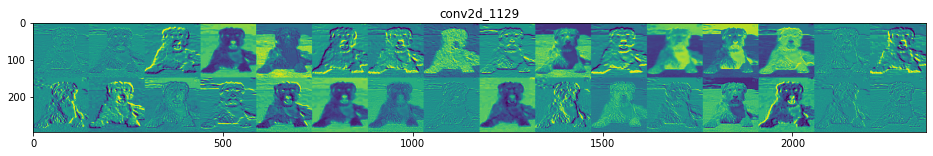

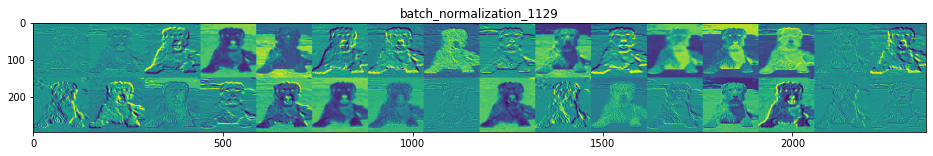

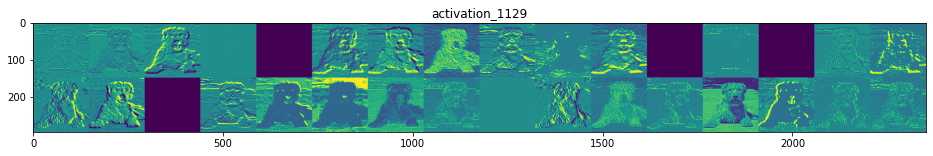

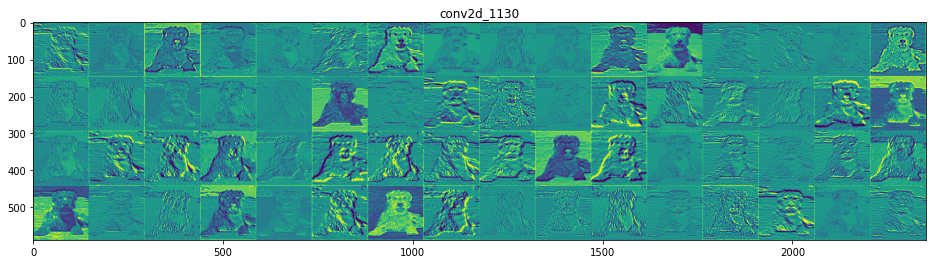

In [ ]:

model, history = initTrainEvaluate()
plot(history)
print("loss validation", history.history['val_loss'])
print("accuracy val", history.history['val_accuracy'])
print("Loss", history.history['loss'])
print("Accuracy", history.history['accuracy'])
#saveModel(model) 

#model = getModel()
map(model)

# print("Loading model...")
# model = getModel()
# print("Evaluating model...")
# test_loss, test_accuracy = evaluate(model)
# print("Test loss: ", test_loss)
# print("Test accuracy: ", test_accuracy * 100, "%")